# Data Ordering attack on Stochastic Gradient Descent


## Motivation

This attack is based on the paper "Manipulating SGD with Data Ordering Attacks" (https://arxiv.org/abs/2104.09667) by Shumailov, Shumaylov, Kazhdan, Zhao, Papernot, Erdogdu and Anderson.


## Explanation

The idea behind this attack is to reorder batches within a data feed to a machine learning model using Stochastic Gradient Descent (SGD). This form of adversarial machine learning exploits SGD's behaviour to attack the model's integrity and availability.


## Simple Attack


### Setup

The attack environment will be using the Abalone Dataset (http://archive.ics.uci.edu/ml) using linear SGD classification with ```sklearn.linear_model.SGDClassifier``` (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) to predict a tree's number of rings (i.e. its age) based on other features about the tree. \
*Note: The 'sex' feature of the Abalone Dataset has been omitted throughout this algorithm and is not considered by any of the models.*

1. Import necessary libraries.
2. Define configuration values.
3. Load the Abalone Dataset.
4. Apply PCA to the dataset to visualise the data on a 2D plane.
5. Split the dataset into feature vectors ~(tree information) and their corresponsing class labels (the tree's age in years).
6. Initialise control, training and surrogate ```SGDClassifier``` models.
7. Train the models over one epoch for a partial fit of each model with the dataset.

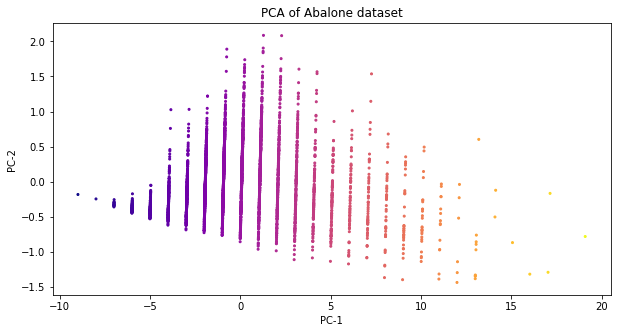

In [27]:
import numpy as np
import pandas as pd
import sorting
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import hinge_loss
from sklearn.decomposition import PCA

# Configuration values
HIGH_LOW = 'highlow'
LOW_HIGH = 'lowhigh'
OSC_IN = 'oscillatingin'
OSC_OUT = 'oscillatingout'
BATCH_REORDER = 'reorder'
BATCH_RESHUFFLE = 'reshuffle'
MAX_BATCH_SIZE = 50

N_TESTDATA_SAMPLES = 150
NUM_ITER = 300
N = 1476

# For determinstic random output
np.random.seed(seed=0)

# Read the abalone.data file into a pandas dataframe
df = pd.read_csv('abalone.data')

# Generate determinstic (for purposes of this project's context) random numbers to represent example batch sizes
batchSizes = []
count = N
while count > 0:
    r = min(np.random.randint(1, MAX_BATCH_SIZE), count)
    batchSizes.append(r)
    count -= r

NUM_BATCHES = len(batchSizes)

# Declare what our feature vectors and class vectors are
features = ['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings']
classVector = 'rings'


# Assign a header/title to each feature
df.set_axis(features, axis=1, inplace=True)
features.remove('sex')


# Visualise the data on a 2D plane through PCA dimensionality reduction
pca = PCA(n_components=2)
pcs = pca.fit(df[features]).components_
reducedData = np.matmul((df[features]-df[features].mean()).to_numpy(), pcs.transpose())
dfReduced = pd.DataFrame(data=reducedData, columns=['PC-1', 'PC-2'])
plt.scatter(reducedData[:, 0], reducedData[:, 1], s=4, c=df[classVector].to_list(), cmap='plasma')

plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.title('PCA of Abalone dataset')
plt.gcf().set_size_inches(10, 5)
plt.show()



# Split dataset into a training dataset and testing dataset
trainingData = df[features][:-N_TESTDATA_SAMPLES]
trainingLabels = df[classVector][:-N_TESTDATA_SAMPLES]

testData = df[features][-N_TESTDATA_SAMPLES:]
testLabels = df[classVector][-N_TESTDATA_SAMPLES:]


# Initialise conmtrol, target and surrogate models.
control = target = surrogate = None

def init_models():
    global control, target, surrogate
    # Create identical SGD Classifier control and target models
    control = SGDClassifier(loss='log', penalty='elasticnet', max_iter=100, tol=0.001, shuffle=False, random_state=0, learning_rate='constant', eta0=0.2)
    target = SGDClassifier(loss='log', penalty='elasticnet', max_iter=100, tol=0.001, shuffle=False, random_state=0, learning_rate='constant', eta0=0.2)

    # Surrogate model which the attacker is using to predict Iris classification, different configuration to the control/target models
    surrogate = SGDClassifier(loss='hinge', max_iter=90, tol=0.001, shuffle=False, random_state=0, learning_rate='constant', eta0=0.2)

    # Get a numpy array of all possible class labels in dataset
    classLabels = np.unique(df[classVector].to_numpy())

    # Train the models over one epoch of datapoints in a currently natural non-malicious order
    control.partial_fit(X=trainingData, y=trainingLabels, classes=classLabels)
    surrogate.partial_fit(X=trainingData, y=trainingLabels, classes=classLabels)
    target.partial_fit(X=trainingData, y=trainingLabels, classes=classLabels)



### Utility Sorting Methods [WORK IN PROGRRESS, NOT IMPLEMENTED YET]
Uses Radix Sort (LSD) to order data batches in ascending order of surrogate model loss (based on implementation at https://stackabuse.com/radix-sort-in-python/). Previously python's built-in ```sorted()``` function based on a TimSort, but this has time complexity $O(n log n)$ for $n$ elements which is much slower than Radix Sort with time complexity $O(d(n + k))$ with $n$ elements where the largest element is $d$ digits long of base $k$ (in this case, $k = 10$). This Radix Sort implementation is specific for handling a dictionary where the keys are each data point's ID and the values are the data point's loss, outputting the data points in ascending order of loss.

In [28]:
def counting_dict(data, order):
    indecies = list(data.keys())
    losses = list(data.values())


    # List to store cumulative base-10 digit frequency
    count = [0] * 10

    n = len(data)
    
    # Read digit of selected order (digit place) and update frequency of this digit
    for i in losses:
        digit = (i // order) % 10
        count[digit] += 1
    
    # Reformat count to use prefix sum to work out element placement later
    for i in range(1, 10):
        count[i] += count[i-1]

    # Sorted list of data points in ascending order of surrogate loss
    indeciesSorted = [None] * n
    lossesSorted = [None] * n

    # Sort
    for i in range(n - 1, -1, -1):
        # Read loss digit of selected order, decrement this digit frequency by 1
        # Use the updated value as the index to allocate for this data point
        digit = (losses[i] // order) % 10
        count[digit] -= 1
        pos = count[digit]
        indeciesSorted[pos] = indecies[i]
        lossesSorted[pos] = losses[i]

    dataSorted = dict(zip(indeciesSorted, lossesSorted))
    
    return dataSorted

def counting_dict2(data):
    indecies = list(data.keys())
    losses = list(data.values())

    n = len(data)
    max_i = max(losses)
    
    count = [0] * max_i

    for i in losses:
        count[i-1] += 1
    
    for i in range(1, max_i):
        count[i] += count[i-1]
    
    indeciesSorted = [None] * n
    lossesSorted = [None] * n

    for i in range(n):
        count[losses[i]-1] -= 1
        pos = count[losses[i]-1]
        indeciesSorted[pos] = indecies[i]
        lossesSorted[pos] = losses[i]

    dataSorted = dict(zip(indeciesSorted, lossesSorted))

    return dataSorted



maxmax_i = 0

def radix_dict(data):
    # Find largest element in the loss scores
    max_i = max(data.values())
    global maxmax_i
    maxmax_i = max(max_i, maxmax_i)

    # Calculate number of digits in largest element
    d = 0
    while int(max_i) > 0:
        max_i /= 10
        d += 1

    # Initialise digit place
    digitPlace = 1

    # Sort the data with counting sort, repeat for d digits, multiply digit places by 10 at each iteration
    dataSorted = data
    while d > 0:
        dataSorted = counting_dict(dataSorted, digitPlace)
        digitPlace *= 10
        d -= 1

    return dataSorted
    



In [29]:
dictionary = {'it': 551, 'doesnt': 553, 'matter': 31}
counting_dict2(dictionary)

{'matter': 31, 'it': 551, 'doesnt': 553}

### Reorder data to attack

The data is reordered based on the specified attack type and the data is then fed in this order into the target and surrogate models. The control model's ordering is not altered by the algorithm. This model is not needed in an actual attack and is only being used in this experiment as a control model for data analysis and comparison after running the algorithm.


In [30]:
#===== ATTACK =====
def attack(attackType, batchType, firstAttackEpoch=False):

    # Stores read data points and their class labels BEFORE reordering
    data = []

    # Stores a data point's corresponding label
    labels = []

    # Stores a data point's index from data as a key, and this data point's loss on surrogate as value
    datacosts = {}

    for i in range(len(trainingData)):
        # Read each datapoint, evaluate the accuracy
        point = trainingData.iloc[i:i+1]
        label = trainingLabels.iloc[i]
        loss = hinge_loss(surrogate.predict(point), [label])

        # Record values
        data.append(point)
        labels.append(label)
        datacosts[i] = loss

    
    # Reorder datapoint indecies by ascending order of loss
    reorderedCosts = dict(sorted(datacosts.items(), key = lambda item: item[1]))

    # Store a list of each data point and corresponding class label AFTER reordering
    reorderedData = []
    reorderedLabels = []

    # Reorder datapoints and their classes based on redordered indecies
    for index in reorderedCosts:
        reorderedData.append(data[index])
        reorderedLabels.append(labels[index])

    # Invert each half of reordered data if oscillating out attack type
    if attackType == OSC_OUT and firstAttackEpoch:
        right = reorderedData[len(reorderedData)//2:][::-1]
        left = reorderedData[:len(reorderedData)//2][::-1]
        reorderedData = left + right

        right = reorderedLabels[len(reorderedLabels)//2:][::-1]
        left = reorderedLabels[:len(reorderedLabels)//2][::-1]
        reorderedLabels = left + right

    # Reverse order of reordered data if high -> low attack type
    if attackType == HIGH_LOW:
        for i in range(len(reorderedData)):
            reorderedData[i] = reorderedData[i][::-1]
        reorderedLabels = reorderedLabels[::-1]
    
    # START OF TO BE COMPLETED WORK
    # Alternate between low and high loss batch if oscillating attack type
    if attackType == OSC_IN or attackType == OSC_OUT:
        osc = False
        start = 0
        end = N - 1
        for i in range(N):
            osc = not osc
            oscillatedData = [None] * N
            oscillatedLabels = [None] * N
            if osc:
                oscillatedData[i] = reorderedData[start]
                oscillatedLabels[i] = reorderedLabels[start]
                start += 1
            else:
                oscillatedData[i] = reorderedData[end]
                oscillatedLabels[i] = reorderedLabels[end]
                end -= 1
        reorderedData = oscillatedData
    #END OF TO BE COMPLETED WORK
    
    # Reformat into one large pandas dataframe
    reorderedData = pd.concat(reorderedData)
    
    # Train control model over one epoch using unaffected data order
    control.partial_fit(X=trainingData, y=trainingLabels)

    # Train target and surrogate models over one epoch using reordered data
    target.partial_fit(X=reorderedData, y=np.ravel(reorderedLabels))
    surrogate.partial_fit(X=reorderedData, y=np.ravel(reorderedLabels))

This is repeated ```NUM_ITER``` times, with the change in accuracy between target and control models being recorded at every iteration.

In [31]:
accuracies = {LOW_HIGH: [], HIGH_LOW: [], OSC_IN: [], OSC_OUT: []}

for j in (LOW_HIGH, HIGH_LOW):#, OSC_IN, OSC_OUT):
    init_models()
    for i in range(NUM_ITER):
        attack(j, None)
        accuracies[j].append(control.score(testData, testLabels) - target.score(testData, testLabels))
    
    # Multiply accuracy change values by 100 for percentages
    accuracies[j] = np.array(accuracies[j]) * 100

### Data Analysis

1. Plot a graph of the difference in accuracy between control and target models versus the number of iterations (epochs) of training on the model.
2. Output the epoch with the largest accuracy change. 

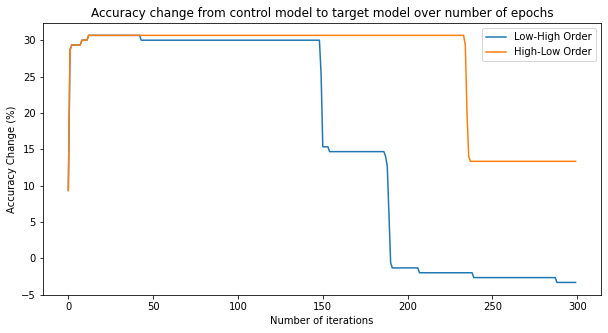

[LOW -> HIGH]: The peak accuracy change is identified after 13 epochs with an accuracy change of 30.67%.
[HIGH -> LOW]: The peak accuracy change is identified after 13 epochs with an accuracy change of 30.67%.


In [32]:
# Plot graph of accuracy variation with number of iterations during training
plt.plot(range(NUM_ITER), accuracies[LOW_HIGH], label="Low-High Order")
plt.plot(range(NUM_ITER), accuracies[HIGH_LOW], label="High-Low Order")
#plt.plot(range(NUM_ITER), accuracies[OSC_IN], label="Oscillating In Order")
#plt.plot(range(NUM_ITER), accuracies[OSC_OUT], label="Oscillating Out Order")
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy Change (%)')
plt.title('Accuracy change from control model to target model over number of epochs')
plt.gcf().set_size_inches(10, 5)
plt.legend()
plt.show()
print("[LOW -> HIGH]: The peak accuracy change is identified after " + str(np.argmax(accuracies[LOW_HIGH]) + 1) + " epochs with an accuracy change of " + str(np.round(np.max(percentageAcc), 2)) + "%.")
print("[HIGH -> LOW]: The peak accuracy change is identified after " + str(np.argmax(accuracies[HIGH_LOW]) + 1) + " epochs with an accuracy change of " + str(np.round(np.max(percentageAcc), 2)) + "%.")

### Data Reorder Variants

The above attack is called with a ```LOW_HIGH``` reordering flag, meaning the data batches are exclusively being reordered in ascending order of each batch's loss on the surrogate model (```sklearn.metrics.hinge_loss()```) and each data batch is only of size one data point. The following experiments will reinvestigate the attack using different reordering methods and batch sizes.